In [1]:
import sagemaker

print(sagemaker.__version__)

sess = sagemaker.Session()
bucket = sess.default_bucket()  
prefix = 'pascalvoc-segmentation'

2.19.0


In [2]:
s3_train_data = 's3://{}/{}/input/train'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/input/validation'.format(bucket, prefix)
s3_train_annotation_data = 's3://{}/{}/input/train_annotation'.format(bucket, prefix)
s3_validation_annotation_data = 's3://{}/{}/input/validation_annotation'.format(bucket, prefix)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

print(s3_train_data)
print(s3_validation_data)
print(s3_train_annotation_data)
print(s3_validation_annotation_data)

s3://sagemaker-eu-west-1-613904931467/pascalvoc-segmentation/input/train
s3://sagemaker-eu-west-1-613904931467/pascalvoc-segmentation/input/validation
s3://sagemaker-eu-west-1-613904931467/pascalvoc-segmentation/input/train_annotation
s3://sagemaker-eu-west-1-613904931467/pascalvoc-segmentation/input/validation_annotation


In [3]:
import boto3
from sagemaker import image_uris

region = boto3.Session().region_name    
container = image_uris.retrieve('semantic-segmentation', region)
print(container)

685385470294.dkr.ecr.eu-west-1.amazonaws.com/semantic-segmentation:1


In [8]:
from sagemaker import get_execution_role
 
role = get_execution_role()

seg = sagemaker.estimator.Estimator(container,
                                    role, 
                                    sagemaker_session = sess,
                                    instance_count = 1, 
                                    instance_type = 'ml.p3.2xlarge',
                                    output_path = s3_output_location)

In [9]:
seg.set_hyperparameters(backbone='resnet-50', 
                             algorithm='fcn',              
                             use_pretrained_model=True, 
                             num_classes=21,
                             epochs=30,
                             num_training_samples=1464) 

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm uses to train.

In [10]:
train_data = sagemaker.TrainingInput(s3_train_data, distribution='FullyReplicated', 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')

validation_data = sagemaker.TrainingInput(s3_validation_data, distribution='FullyReplicated', 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation = sagemaker.TrainingInput(s3_train_annotation_data, distribution='FullyReplicated', 
                                        content_type='image/png', s3_data_type='S3Prefix')

validation_annotation = sagemaker.TrainingInput(s3_validation_annotation_data, distribution='FullyReplicated', 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

In [11]:
seg.fit(inputs=data_channels)

2020-12-16 18:50:40 Starting - Starting the training job...
2020-12-16 18:51:03 Starting - Launching requested ML instancesProfilerReport-1608144639: InProgress
.........
2020-12-16 18:52:37 Starting - Preparing the instances for training......
2020-12-16 18:53:33 Downloading - Downloading input data.........
2020-12-16 18:55:09 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[12/16/2020 18:55:13 INFO 140663167997760] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_h

[12/16/2020 18:56:11 INFO 140663167997760] #progress_notice. epoch: 1, iterations: 20 speed: 76.7456634707 samples/sec learning_rate: 0.000963
[12/16/2020 18:56:16 INFO 140663167997760] #progress_notice. epoch: 1, iterations: 40 speed: 79.095092509 samples/sec learning_rate: 0.000957
[12/16/2020 18:56:20 INFO 140663167997760] #progress_notice. epoch: 1, iterations: 60 speed: 76.523906286 samples/sec learning_rate: 0.000950
[12/16/2020 18:56:24 INFO 140663167997760] #progress_notice. epoch: 1, iterations: 80 speed: 78.9838487006 samples/sec learning_rate: 0.000943
[12/16/2020 18:56:26 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 1, train loss: 1.8869497529838397 .
[12/16/2020 18:56:26 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 1, train throughput: 76.4044248075 samples/sec.
[12/16/2020 18:56:30 INFO 140663167997760] #progress_notice. epoch: 1, iterations: 20 speed: 114.211523799 samples/sec
[12/16/2020 18:56:32 INFO 140663167997760] #progress_notice. e

[12/16/2020 18:57:50 INFO 140663167997760] #progress_notice. epoch: 4, iterations: 20 speed: 78.5642368042 samples/sec learning_rate: 0.000872
[12/16/2020 18:57:54 INFO 140663167997760] #progress_notice. epoch: 4, iterations: 40 speed: 67.3196417985 samples/sec learning_rate: 0.000865
[12/16/2020 18:57:58 INFO 140663167997760] #progress_notice. epoch: 4, iterations: 60 speed: 75.3475962127 samples/sec learning_rate: 0.000858
[12/16/2020 18:58:03 INFO 140663167997760] #progress_notice. epoch: 4, iterations: 80 speed: 79.9556596603 samples/sec learning_rate: 0.000852
[12/16/2020 18:58:05 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 4, train loss: 1.6172958116282474 .
[12/16/2020 18:58:05 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 4, train throughput: 75.7950669627 samples/sec.
[12/16/2020 18:58:08 INFO 140663167997760] #progress_notice. epoch: 4, iterations: 20 speed: 123.051313505 samples/sec
[12/16/2020 18:58:11 INFO 140663167997760] #progress_notice.

[12/16/2020 18:59:36 INFO 140663167997760] #progress_notice. epoch: 7, iterations: 60 speed: 79.3780985601 samples/sec learning_rate: 0.000766
[12/16/2020 18:59:40 INFO 140663167997760] #progress_notice. epoch: 7, iterations: 80 speed: 80.5311521994 samples/sec learning_rate: 0.000759
[12/16/2020 18:59:42 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 7, train loss: 1.4979252373880667 .
[12/16/2020 18:59:42 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 7, train throughput: 76.8645053478 samples/sec.
[12/16/2020 18:59:45 INFO 140663167997760] #progress_notice. epoch: 7, iterations: 20 speed: 126.130255986 samples/sec
[12/16/2020 18:59:48 INFO 140663167997760] #progress_notice. epoch: 7, iterations: 40 speed: 121.644327066 samples/sec
[12/16/2020 18:59:51 INFO 140663167997760] #progress_notice. epoch: 7, iterations: 60 speed: 125.1769481 samples/sec
[12/16/2020 18:59:53 INFO 140663167997760] #progress_notice. epoch: 7, iterations: 80 speed: 103.641592627 sam

[12/16/2020 19:01:19 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 10, train loss: 1.4024519522438992 .
[12/16/2020 19:01:19 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 10, train throughput: 77.4171566268 samples/sec.
[12/16/2020 19:01:22 INFO 140663167997760] #progress_notice. epoch: 10, iterations: 20 speed: 128.674186689 samples/sec
[12/16/2020 19:01:25 INFO 140663167997760] #progress_notice. epoch: 10, iterations: 40 speed: 125.419312397 samples/sec
[12/16/2020 19:01:27 INFO 140663167997760] #progress_notice. epoch: 10, iterations: 60 speed: 128.175288547 samples/sec
[12/16/2020 19:01:30 INFO 140663167997760] #progress_notice. epoch: 10, iterations: 80 speed: 126.597328413 samples/sec
[12/16/2020 19:01:31 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 10, validation pixel_accuracy: 0.8359279733195212 .
[12/16/2020 19:01:31 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 10, validation mIOU: 0.47392457054428744 .
[12/16/2020 

[12/16/2020 19:03:02 INFO 140663167997760] #progress_notice. epoch: 13, iterations: 40 speed: 124.242082696 samples/sec
[12/16/2020 19:03:05 INFO 140663167997760] #progress_notice. epoch: 13, iterations: 60 speed: 106.40782906 samples/sec
[12/16/2020 19:03:08 INFO 140663167997760] #progress_notice. epoch: 13, iterations: 80 speed: 125.007663392 samples/sec
[12/16/2020 19:03:09 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 13, validation pixel_accuracy: 0.8455377020726181 .
[12/16/2020 19:03:09 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 13, validation mIOU: 0.5049626285596868 .
[12/16/2020 19:03:09 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 13, validation throughput: 123.619658124 samples/sec.
[12/16/2020 19:03:09 INFO 140663167997760] Serializing model to /opt/ml/model/model_best.params
[12/16/2020 19:03:09 INFO 140663167997760] #progress_metric: host=algo-1, completed 46 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Rese

[12/16/2020 19:04:45 INFO 140663167997760] #progress_notice. epoch: 16, iterations: 80 speed: 126.3803754 samples/sec
[12/16/2020 19:04:46 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 16, validation pixel_accuracy: 0.8457365393401404 .
[12/16/2020 19:04:46 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 16, validation mIOU: 0.5105958954271872 .
[12/16/2020 19:04:46 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 16, validation throughput: 124.144459001 samples/sec.
[12/16/2020 19:04:46 INFO 140663167997760] Serializing model to /opt/ml/model/model_best.params
[12/16/2020 19:04:47 INFO 140663167997760] #progress_metric: host=algo-1, completed 56 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": 

[12/16/2020 19:06:29 INFO 140663167997760] #progress_notice. epoch: 20, iterations: 20 speed: 76.3187861571 samples/sec learning_rate: 0.000361
[12/16/2020 19:06:33 INFO 140663167997760] #progress_notice. epoch: 20, iterations: 40 speed: 75.7855518289 samples/sec learning_rate: 0.000354
[12/16/2020 19:06:37 INFO 140663167997760] #progress_notice. epoch: 20, iterations: 60 speed: 75.0619811509 samples/sec learning_rate: 0.000346
[12/16/2020 19:06:42 INFO 140663167997760] #progress_notice. epoch: 20, iterations: 80 speed: 78.7460312431 samples/sec learning_rate: 0.000339
[12/16/2020 19:06:44 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 20, train loss: 1.267263620191223 .
[12/16/2020 19:06:44 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 20, train throughput: 76.3624840872 samples/sec.
[12/16/2020 19:06:47 INFO 140663167997760] #progress_notice. epoch: 20, iterations: 20 speed: 128.017580539 samples/sec
[12/16/2020 19:06:50 INFO 140663167997760] #progress_n

[12/16/2020 19:08:19 INFO 140663167997760] #progress_notice. epoch: 23, iterations: 80 speed: 77.5615197738 samples/sec learning_rate: 0.000235
[12/16/2020 19:08:21 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 23, train loss: 1.2351476661860943 .
[12/16/2020 19:08:21 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 23, train throughput: 75.5543599162 samples/sec.
[12/16/2020 19:08:24 INFO 140663167997760] #progress_notice. epoch: 23, iterations: 20 speed: 121.36932818 samples/sec
[12/16/2020 19:08:27 INFO 140663167997760] #progress_notice. epoch: 23, iterations: 40 speed: 127.772134884 samples/sec
[12/16/2020 19:08:30 INFO 140663167997760] #progress_notice. epoch: 23, iterations: 60 speed: 119.114064608 samples/sec
[12/16/2020 19:08:32 INFO 140663167997760] #progress_notice. epoch: 23, iterations: 80 speed: 125.571854663 samples/sec
[12/16/2020 19:08:34 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 23, validation pixel_accuracy: 0.853378069664

[12/16/2020 19:09:59 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 26, train loss: 1.1911888509825035 .
[12/16/2020 19:09:59 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 26, train throughput: 77.1510673591 samples/sec.
[12/16/2020 19:10:02 INFO 140663167997760] #progress_notice. epoch: 26, iterations: 20 speed: 127.864888862 samples/sec
[12/16/2020 19:10:05 INFO 140663167997760] #progress_notice. epoch: 26, iterations: 40 speed: 122.384158907 samples/sec
[12/16/2020 19:10:08 INFO 140663167997760] #progress_notice. epoch: 26, iterations: 60 speed: 122.509495514 samples/sec
[12/16/2020 19:10:10 INFO 140663167997760] #progress_notice. epoch: 26, iterations: 80 speed: 122.616715329 samples/sec
[12/16/2020 19:10:12 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 26, validation pixel_accuracy: 0.8538420148652628 .
[12/16/2020 19:10:12 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 26, validation mIOU: 0.5266858892897253 .
[12/16/2020 1

[12/16/2020 19:11:48 INFO 140663167997760] #progress_notice. epoch: 29, iterations: 80 speed: 128.117784065 samples/sec
[12/16/2020 19:11:49 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 29, validation pixel_accuracy: 0.8514840408710085 .
[12/16/2020 19:11:49 INFO 140663167997760] #quality_metric. host: algo-1, epoch: 29, validation mIOU: 0.5301258878893262 .
[12/16/2020 19:11:49 INFO 140663167997760] #throughput_metric. host: algo-1, epoch: 29, validation throughput: 125.100075852 samples/sec.
[12/16/2020 19:11:49 INFO 140663167997760] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "s

In [12]:
seg_predictor = seg.deploy(initial_instance_count=1, instance_type='ml.c5.2xlarge')

-------------!

In [13]:
!wget -O test.jpg https://upload.wikimedia.org/wikipedia/commons/e/ea/SilverMorgan.jpg
filename = 'test.jpg'

--2020-12-16 19:19:36--  https://upload.wikimedia.org/wikipedia/commons/e/ea/SilverMorgan.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100288 (98K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  97.94K  --.-KB/s    in 0.05s   

2020-12-16 19:19:36 (1.98 MB/s) - ‘test.jpg’ saved [100288/100288]



Let's convert the image to bytearray before we supply it to our endpoint.

(-0.5, 336.5, 288.5, -0.5)

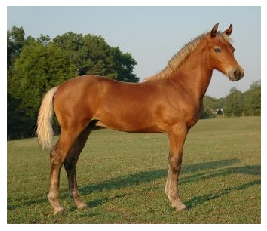

In [14]:
import matplotlib.pyplot as plt
import PIL

im = PIL.Image.open(filename)
im.save(filename, "JPEG")

%matplotlib inline
plt.imshow(im)
plt.axis('off')

In [28]:
import boto3, json
import numpy as np

runtime = boto3.Session().client(service_name='runtime.sagemaker')

with open(filename, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=seg_predictor.endpoint_name, 
                                   ContentType='image/jpeg', 
                                   Accept='image/png', 
                                   Body=payload)

result = response['Body'].read()

Let's display the segmentation mask.

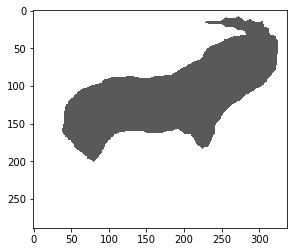

In [29]:
import PIL
from PIL import Image
import numpy as np
import io

num_classes = 21
mask = np.array(Image.open(io.BytesIO(result)))
plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='gray_r')
plt.show()

In [30]:
response = runtime.invoke_endpoint(EndpointName=seg_predictor.endpoint_name, 
                                   ContentType='image/jpeg', 
                                   Accept='application/x-protobuf', 
                                   Body=payload)

result = response['Body'].read()

results_file = 'results.rec'
with open(results_file, 'wb') as f:
    f.write(result)

In [33]:
from sagemaker.amazon.record_pb2 import Record
import mxnet as mx

rec = Record()
recordio = mx.recordio.MXRecordIO(results_file, 'r')
protobuf = rec.ParseFromString(recordio.read())

values = list(rec.features["target"].float32_tensor.values)
shape = list(rec.features["shape"].int32_tensor.values)

In [34]:
print(shape)
print(len(values))
mask = np.reshape(np.array(values), shape)

[1, 21, 289, 337]
2045253


In [35]:
pixel_probs = mask[0,:,0,0]
print(pixel_probs)
print(np.argmax(pixel_probs))

[9.06280458e-01 6.49556576e-04 2.42808042e-03 1.76016404e-03
 1.04017893e-03 2.09418731e-03 7.90971704e-03 2.77346256e-03
 6.32661814e-03 4.96556191e-03 2.33698334e-03 3.37589416e-03
 7.52270687e-03 7.64450245e-03 3.04348860e-03 1.69293545e-02
 3.33644450e-03 2.46872194e-03 9.47848614e-03 4.06038482e-03
 3.57495015e-03]
0


In [36]:
print(mask.shape)

(1, 21, 289, 337)


In [37]:
seg_predictor.delete_endpoint()